In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
""" 결정트리 예시 """

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[ : , 2 : ]
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file="iris_tree.dot",
    feature_names=iris.feature_names[2: ],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

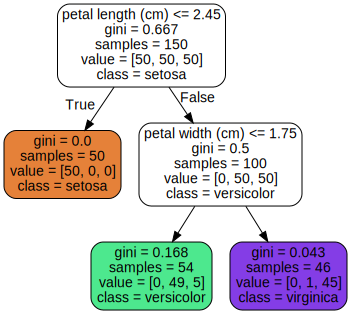

In [4]:
import graphviz
with open("iris_tree.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='iris_tree', directory='.', cleanup=True)
dot

결정 트리의 장점 중 하나는 데이터 전처리가 거의 필요 없다는 점 <br>
\>>> 스케일링 등이 필요 없음 <br>

결과 해석 <br><br>

- sample: 얼마나 많은 훈련 샘플에 적용되었나
- value: 각 클래스에 얼마나 많은 훈련 샘플이 있는가
- genie: 불순도 >>> 0에 가까울 수록 덜 섞인 것. 즉 같은 클래스로 분류된 정도

지니 불순도: $G_i=1-\sum_{k=1}^n {p_{i, k}}^2$

사이킷런은 이진 트리만 생성 가능 (CART 알고리즘)<br>
\>>> 질문의 답이 YES or NO <br>
\>>> 3개 이상부턴 다른 알고리즘 사용?

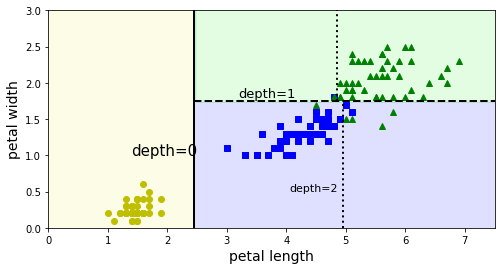

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("petal length", fontsize=14)
        plt.ylabel("petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "depth=0", fontsize=15)
plt.text(3.2, 1.80, "depth=1", fontsize=13)
plt.text(4.05, 0.5, "depth=2", fontsize=11)

plt.show()

#### 화이트박스 모델? 블랙박스 모델? <br>
<br>
화이트박스 모델: 결과 확인 O, 결정 방식 확인 O. 대표 사례: 결정 트리 <br>
블랙박스 모델: 결과 확인 O, 결정 방식 확인 X. 대표 사례: 신경망, 랜덤 포레스트

# 클래스 확률 추정

어떤 샘플이 특정 클래스에 속할 것이라고 예측하는 것이 아닌, ~% 확률로 특정 클래스일 것을 추정하는 것 <br>
ex. 길이가 ~이고 너비가 ~인 표본은 90% 확률로 Versicolor

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

# CART 알고리즘

과정  
1. 훈련 세트를 가장 순수한 서브셋으로 나눌 수 있는 특성 $k$의 임계값 $t_k$ >>> $\left (k, t_k \right )$ 쌍을 찾아낸다  
2. 훈련 세트를 하나의 특성 $k$의 임계값 $t_k$를 사용해 두 개의 서브셋으로 나눈다  
3. 2를 최대 깊이(아까 max_depth)에 도달하거나, 더 깔끔하게 나눌 수 있는 조합이 없을 때까지 한다

$\left (k, t_k \right )$는 다음 비용함수를 최소하하는 값으로 한다  

$ J(k, t_k)={ m_{left} \over m}G_{left} + {m_{right} \over m}G_{right}$

여기서 
$
\begin{cases}
G_{left, right} 는 왼쪽/오른쪽 서브셋의 불순도 \\
m_{left, right} 는 왼쪽/오른쪽 서브셋의 샘플 수
\end{cases}
$  

주의사항  
이렇게 만든 트리는 **최적이 아니라 봐줄 만한 결과이다**  
이유: 현재 단계에서 분할했을 때 그 다음도 불순도가 가장 낮을지는 고려하지 않기 때문  
\>>> CART는 탐욕적 알고리즘이기 때문  
  
만약 진짜 최적의 트리를 찾아내려면 $\mathbf {\mathit O} (\exp(m)) $만큼의 시간 필요

# 계산 복잡도

모델을 이용해 새로운 샘플을 분류할 때: $\mathbf {\mathit O} (\log_{2}(m)) $  
훈련 복잡도: $\mathbf {\mathit O} (n \times m \log (m)) $  
  
- n: 특성 수
- m: 샘플 수  
  
$n \times m \log (m)$?  
\>>> 특성 별로 정렬을 수행해야 하기 때문 (이때 퀵 정렬 사용)

# 엔트로피

사용:  criterion="entropy"로 설정 (기본 "gini")  
각 장점  
- 지니: 로그 계산을 할 필요가 없다 (식 참고) >>> 빠른 계산 속도
- 엔트로피: 지니 불순도를 쓸 때보다 비교적 균형 잡힌 트리를 형성한다  

엔트로피: $ H_i = -\sum_{k=1}^n \left( p_{i, k}\log_{2} \left( p_{i, k} \right) \right)$  
(여기서 $p_{i, k} \ne 0$ >>> 클래스에 샘플이 하나라도 있을 때)  

어떤 세트에 있는 샘플들이 모두 같은 클래스라면 $H_i = 0$, 반반에 가까울수록 $H_i \simeq 1$

# 규제 매개변수

비파라미터 모델: 훈련 전 파라미터 수가 결정되지 않는 모델. ~ 결정 트리  
파라미터 모델: 파라미터 수가 미리 정해진 모델. ~ 선형 모델  
    파라미터 모델의 경우 비파라미터 모델보다 자유도가 제한되어 비교적 과대적합 가능성은 줄지만  
    과소적합될 위험은 커질 수 있다

sklearn의 결정 트리에서 사용할 수 있는 규제
- max_depth: 트리의 최대 깊이 제한
- min_samples_split: 분할되기 위해 노드가 가져가야 하는 최소 샘플 수
- min_samples_leaf: 리프 노드가 가지고 있어야 할 최소 샘플 수
- min_weight_fraction_leaf: min_samples_leaf와 같지만 여기는 전체 샘플에서의 최소 비율
- max_leaf_noeds: 리프 노드의 최대 수
- max_features: 각 노드에서 분할에 사용할 특성의 최대 수
- min_impurity_decrease: 분할로 얻어질 최소한의 불순도 감소량 >>> 분할 후 불순도가 ~ 보다 높아야 함
- min_impurity_split: 분할 대상이 되기 위한 최소한의 불순도 >>> ~ 보다 높아야 분할

### 사후 가지치기: 트리를 깔끔하게 만드는 다른 방법  

처음엔 규제를 가하지 않고 만든 뒤, 불필요한 노드를 없애는 방식  
통계적 검정을 통해 판단  
(ex. 카이제곱 검정을 통해 산출한 p값이 기준을 넘어서면 우연히 생성된 결과라고 판단, 제거)  
<br>
단, 사이킷런에선 불가능 (사전 가지치기만 지원)

# 트리를 이용한 회귀

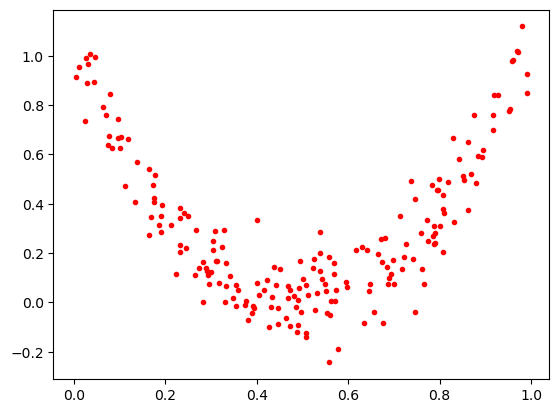

In [7]:
X = np.random.rand(200, 1)
y = 4*(X-0.5)**2
y = y + np.random.randn(200, 1) / 10

plt.plot(X, y, "r.")

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2)

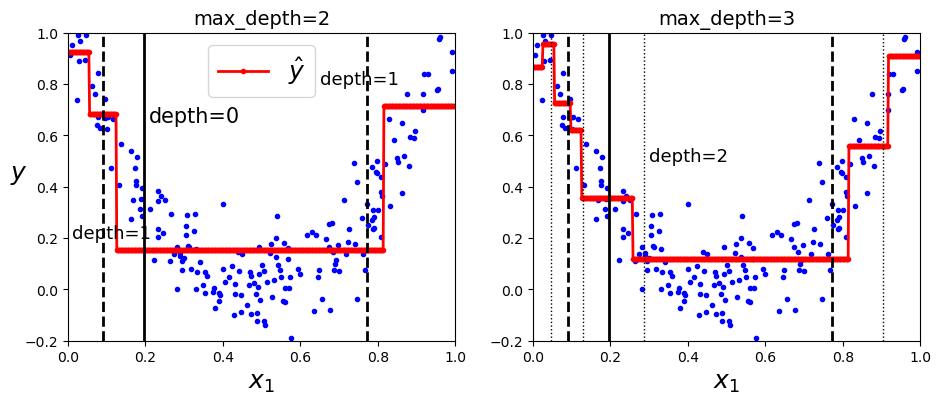

In [9]:
tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "depth=0", fontsize=15)
plt.text(0.01, 0.2, "depth=1", fontsize=13)
plt.text(0.65, 0.8, "depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.subplot(122)
plot_regression_predictions(tree_reg2, X, y, ylabel=None)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "depth=2", fontsize=13)
plt.title("max_depth=3", fontsize=14)

plt.show()

In [10]:
export_graphviz(
    tree_reg1,
    out_file="tree_reg1.dot",
    rounded=True,
    filled=True
)

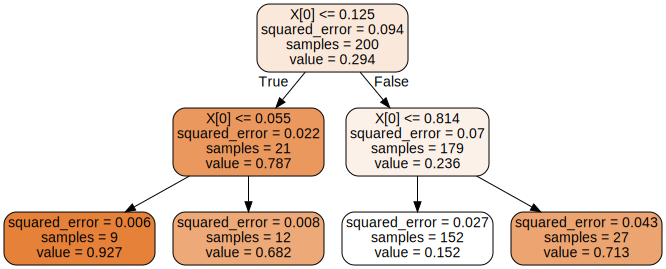

In [11]:
with open("tree_reg1.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='tree_reg1', directory='.', cleanup=True)
dot

In [12]:
export_graphviz(
    tree_reg2,
    out_file="tree_reg2.dot",
    rounded=True,
    filled=True
)

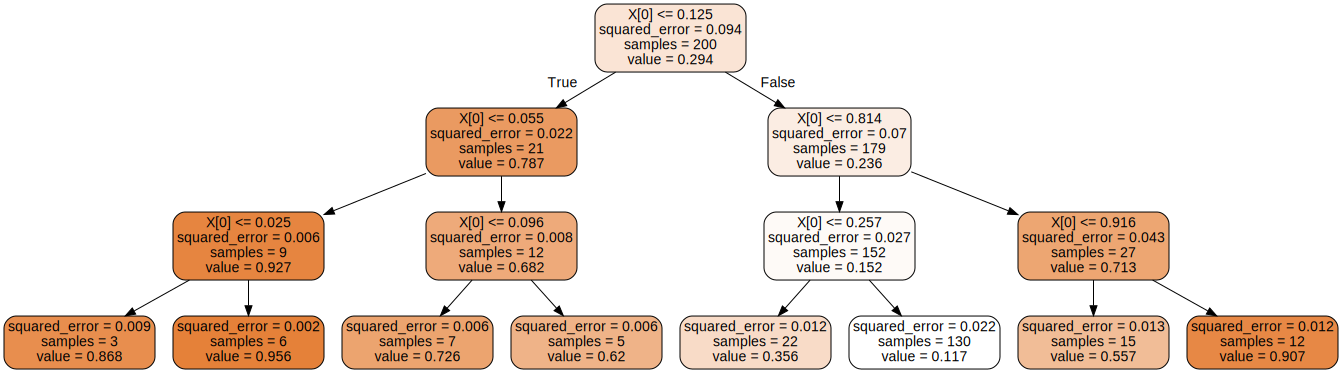

In [13]:
with open("tree_reg2.dot") as f:
    dot_graph = f.read()
dot = graphviz.Source(dot_graph)
dot.format = 'png'
dot.render(filename='tree_reg2', directory='.', cleanup=True)
dot

트리를 회귀 작업에 이용할 경우 CART 비용함수에 불순도 대신 MSE 사용  
식: $J(k, t_k)= { m_{left} \over m }\mbox{MSE}_{left} + { m_{right} \over m } \mbox{MSE}_{right} $  
  
각 노드의 MSE: $\mbox{MSE}_{node} = \sum_{ i \in \mbox{node} } \left ( \hat{y}_{node} - y_(i) \right )^2$

# 불안정성: 트리의 단점

1. 훈련 세트의 회전에 민감하다
2. 훈련 데이터의 작은 변화에도 민감하다
    - 같은 데이터에서도 다른 모델이 나올 수 있다.
    - 각 노드에서 평가할 후보 특성을 무작위로 선택한다